<a href="https://colab.research.google.com/github/jarek-pawlowski/machine-learning-applications/blob/main/advancedCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using advanced CNNs
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 30

### Download CIFAR-10 dataset and define models
Similar as with MNIST we use torchvision to download the data

In [ ]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#mean = [.5, .5, .5]
#std = [.5, .5, .5]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's show some of the training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


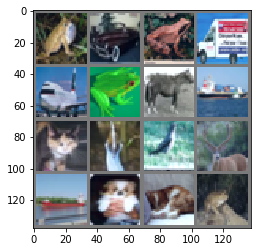

In [ ]:
def imshow(img):
    npimg = img.numpy()*std[0]+mean[0] # this should be done for each channel separately ;)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# get some random training images
dataiter = iter(train_loader)
images, _ = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4))


Now define CNN models
- VGG definition borrowed from *https://github.com/chengyangfu/pytorch-vgg-cifar10*


In [ ]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}

Define util methods

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target) 
            # get the index of class with the max probability 
            prediction = output.argmax(dim=1)  
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss, accuracy

def run_training(model, criterion, optimizer, no_epochs):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train(model, device, train_loader, 
                                optimizer, criterion, epoch_number))
        val_loss, val_acc = test(model, device, validation_loader, 
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Do the experiments

Train Epoch: 1
	Train set: Average loss: 1.9752
	Validation set: Average loss: 1.7950, Accuracy: 1717/5000 (34%)
Train Epoch: 2
	Train set: Average loss: 1.6907
	Validation set: Average loss: 1.7549, Accuracy: 1909/5000 (38%)
Train Epoch: 3
	Train set: Average loss: 1.6541
	Validation set: Average loss: 1.6460, Accuracy: 2016/5000 (40%)
Train Epoch: 4
	Train set: Average loss: 1.5979
	Validation set: Average loss: 1.6618, Accuracy: 1992/5000 (40%)
Train Epoch: 5
	Train set: Average loss: 1.5554
	Validation set: Average loss: 1.5891, Accuracy: 2086/5000 (42%)
Train Epoch: 6
	Train set: Average loss: 1.5227
	Validation set: Average loss: 1.5771, Accuracy: 2199/5000 (44%)
Train Epoch: 7
	Train set: Average loss: 1.4942
	Validation set: Average loss: 1.6035, Accuracy: 2141/5000 (43%)
Train Epoch: 8
	Train set: Average loss: 1.4633
	Validation set: Average loss: 1.5144, Accuracy: 2370/5000 (47%)
Train Epoch: 9
	Train set: Average loss: 1.4456
	Validation set: Average loss: 1.5272, Accuracy:

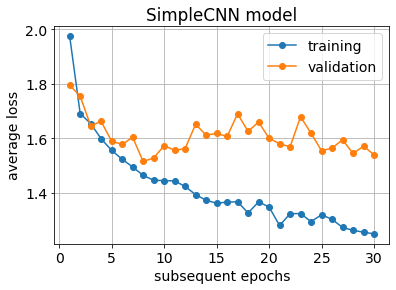

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=model_args['weight_decay'])
no_epochs = model_args['epochs']

train_loss, val_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, val_loss, 'SimpleCNN model')

Train Epoch: 1
	Train set: Average loss: 2.1837
	Validation set: Average loss: 1.9117, Accuracy: 1317/5000 (26%)
Train Epoch: 2
	Train set: Average loss: 1.8522
	Validation set: Average loss: 1.7018, Accuracy: 1623/5000 (32%)
Train Epoch: 3
	Train set: Average loss: 1.6630
	Validation set: Average loss: 1.5457, Accuracy: 2051/5000 (41%)
Train Epoch: 4
	Train set: Average loss: 1.4726
	Validation set: Average loss: 1.3392, Accuracy: 2496/5000 (50%)
Train Epoch: 5
	Train set: Average loss: 1.3067
	Validation set: Average loss: 1.3182, Accuracy: 2584/5000 (52%)
Train Epoch: 6
	Train set: Average loss: 1.1603
	Validation set: Average loss: 1.1743, Accuracy: 2928/5000 (59%)
Train Epoch: 7
	Train set: Average loss: 1.0298
	Validation set: Average loss: 1.2103, Accuracy: 2905/5000 (58%)
Train Epoch: 8
	Train set: Average loss: 0.8993
	Validation set: Average loss: 1.2728, Accuracy: 2885/5000 (58%)
Train Epoch: 9
	Train set: Average loss: 0.7884
	Validation set: Average loss: 1.0171, Accuracy:

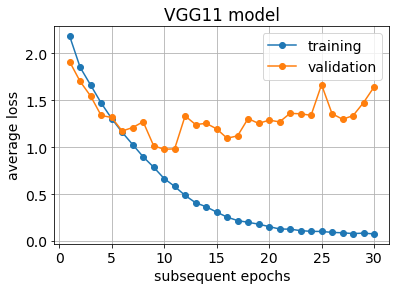

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.5,
                      weight_decay=1.e-3)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_11, val_loss_11, 'VGG11 model')

Train Epoch: 1
	Train set: Average loss: 2.1799
	Validation set: Average loss: 1.9768, Accuracy: 1108/5000 (22%)
Train Epoch: 2
	Train set: Average loss: 1.9814
	Validation set: Average loss: 1.9203, Accuracy: 1006/5000 (20%)
Train Epoch: 3
	Train set: Average loss: 1.9221
	Validation set: Average loss: 1.8839, Accuracy: 1070/5000 (21%)
Train Epoch: 4
	Train set: Average loss: 1.8725
	Validation set: Average loss: 1.9117, Accuracy: 1308/5000 (26%)
Train Epoch: 5
	Train set: Average loss: 1.7940
	Validation set: Average loss: 1.8084, Accuracy: 1493/5000 (30%)
Train Epoch: 6
	Train set: Average loss: 1.6984
	Validation set: Average loss: 1.6412, Accuracy: 1640/5000 (33%)
Train Epoch: 7
	Train set: Average loss: 1.6386
	Validation set: Average loss: 1.5972, Accuracy: 1885/5000 (38%)
Train Epoch: 8
	Train set: Average loss: 1.5826
	Validation set: Average loss: 1.6788, Accuracy: 1777/5000 (36%)
Train Epoch: 9
	Train set: Average loss: 1.4936
	Validation set: Average loss: 1.4756, Accuracy:

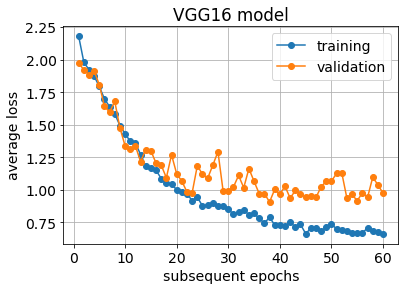

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg16'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_16, val_loss_16, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_16, val_loss_16, 'VGG16 model')

Now compare training curves for both VGGs:

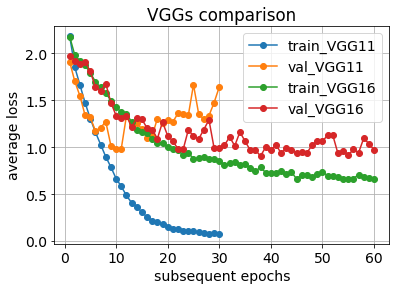

In [ ]:
plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
plt.plot(range(1, len(train_loss_11)+1), train_loss_11, 'o-', label='train_VGG11')
plt.plot(range(1, len(val_loss_11)+1), val_loss_11, 'o-', label='val_VGG11')
plt.plot(range(1, len(train_loss_16)+1), train_loss_16, 'o-', label='train_VGG16')
plt.plot(range(1, len(val_loss_16)+1), val_loss_16, 'o-', label='val_VGG16')
plt.legend()
plt.title("VGGs comparison")
plt.show()

Let's check residual network: ResNet
- implementarion borrowed from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

Train Epoch: 1
	Train set: Average loss: 1.8482
	Validation set: Average loss: 1.7366, Accuracy: 1815/5000 (36%)
Train Epoch: 2
	Train set: Average loss: 1.4233
	Validation set: Average loss: 1.3694, Accuracy: 2513/5000 (50%)
Train Epoch: 3
	Train set: Average loss: 1.2070
	Validation set: Average loss: 1.1456, Accuracy: 2885/5000 (58%)
Train Epoch: 4
	Train set: Average loss: 1.0218
	Validation set: Average loss: 1.0898, Accuracy: 3090/5000 (62%)
Train Epoch: 5
	Train set: Average loss: 0.8913
	Validation set: Average loss: 1.1527, Accuracy: 2972/5000 (59%)
Train Epoch: 6
	Train set: Average loss: 0.7586
	Validation set: Average loss: 0.9591, Accuracy: 3370/5000 (67%)
Train Epoch: 7
	Train set: Average loss: 0.6557
	Validation set: Average loss: 0.7906, Accuracy: 3622/5000 (72%)
Train Epoch: 8
	Train set: Average loss: 0.5627
	Validation set: Average loss: 0.8403, Accuracy: 3617/5000 (72%)
Train Epoch: 9
	Train set: Average loss: 0.4831
	Validation set: Average loss: 0.7952, Accuracy:

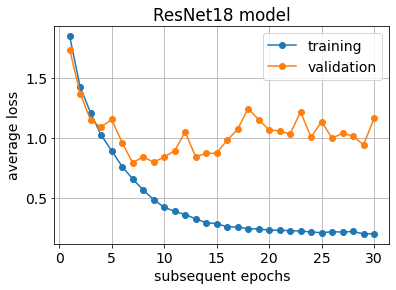

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss, validation_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, validation_loss, 'ResNet18 model')

### Tasks to do:

1. Check turning off the data normalization -- how this impacts network training.
2. What happens if we put *weight_decay* = 0. and increase *momentum* to .9 for VGG11 model -- why is that? (hint: obserwe interplay between *learning rate* and *momentum*)
3. Try to explain why the deeper VGG16 network trains longer than VGG11.
4. Compare with performance for deeper VGGs: 19 or 22 -- do we observe saturation in accuracy or even *degradation* problem?
5. Does ResNet18 (with similar depth) performs better, what for ResNet34? What about training time in this case?
